# Review of data ingested from TAPoR

In this document we perform some (basic) quantitative data analysys of data ingested from TAPoR.
Reference to ticket: https://gitlab.gwdg.de/sshoc/data-ingestion/-/issues/7


In [1]:
import ast
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

from im_tutorials.data import *
from im_tutorials.utilities import flatten_lists
from im_tutorials.features.text_preprocessing import *
from im_tutorials.features.document_vectors import document_vector
from im_tutorials.features.dim_reduction import WrapTSNE, GaussianMixtureEval
# for db
import sqlalchemy as db
from sqlalchemy import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cesare/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cesare/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
engine = create_engine(
      "connection_string")
connection = engine.connect()
metadata = db.MetaData()

## Query the DB to get TAPoR data

The TAPoR data used is the sql dump published by Education and Research Archive (ERA) University of Alberta  here: https://era.library.ualberta.ca/items/f2da0666-f523-44d4-a83c-fa06351a1e94 (creation date: 2020-01-01).
The table *tool* contains 1504 records, each one describing a tool. 
We filtered these records according the value of the field *tool.is_approved*, the number of records actually published is 1363

In [3]:
df_db_tools=pd.read_sql_query('SELECT * FROM TaPOR.tools where is_approved=1 order by last_updated', connection)
df_db_tools.index

RangeIndex(start=0, stop=1363, step=1)

In [259]:
df_db_tools.dtypes

id                            int64
user_id                     float64
name                         object
detail                       object
url                          object
is_approved                   int64
creators_name                object
creators_email               object
creators_url                 object
image_url                    object
star_average                float64
is_hidden                     int64
last_updated                 object
documentation_url            object
code                         object
repository                   object
language                    float64
nature                        int64
created_at           datetime64[ns]
updated_at           datetime64[ns]
recipes                      object
correctdata          datetime64[ns]
justdata                    float64
dtype: object

The database tables are described here: https://era.library.ualberta.ca/items/f2da0666-f523-44d4-a83c-fa06351a1e94/download/8057eae2-3fae-4afa-bc8e-6dcc2a257b6f.

In [260]:
df_db_tools.head()

,id,user_id,name,detail,url,is_approved,creators_name,creators_email,creators_url,image_url,...,documentation_url,code,repository,language,nature,created_at,updated_at,recipes,correctdata,justdata
0,1024,1.0,Adapter,<p>Adapter is a free video converter that conv...,None,1,Macroplant,None,None,None,...,None,None,None,NaN,0,2015-05-19,2015-05-19 00:00:00,,NaT,NaN
1,1281,1.0,PDF to Word Converter,<p>The PDF to Word Converter is Windows softwa...,None,1,n/a,None,None,None,...,None,None,None,NaN,0,2014-12-29,2014-12-29 00:00:00,,NaT,NaN
2,1285,1.0,iTunesCyrFix,<p>iTunesCyrFix can convert jibberish text in ...,None,1,n/a,None,None,None,...,None,None,None,NaN,0,2014-12-29,2014-12-29 00:00:00,,NaT,NaN
3,1286,1.0,Bamboo Person Service,<p>The Bamboo Person Service can help scholars...,None,1,Project Bamboo,None,None,None,...,None,None,None,NaN,0,2014-12-29,2014-12-29 00:00:00,,NaT,NaN
4,775,1.0,Xendo,<p>Xendo is an online research tool that provi...,None,1,"Xendo, Inc.",None,None,images/tools/1/775.png,...,None,None,None,NaN,0,2015-08-02,2018-08-08 22:19:04,,NaT,NaN


## Get the description fo TAPoR tools from the Market Place dataset  using the API

In [255]:
#x = ('2','3','4','5')
x = pd.Series(range(2,69))
url = 'https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools?page=1&perpage=20'
df_tool_all = pd.read_json(url, orient='columns')
for var in x:
    url = "https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools?page="+str(var)+"&perpage=20"
    df_tool_par=pd.read_json(url, orient='columns')
    df_tool_all=df_tool_all.append(df_tool_par, ignore_index=True)
   # print("url: "+ url + ":",var)
df_tool_all.index

RangeIndex(start=0, stop=1353, step=1)

There are 1353 tool descriptions in MP dataset.

In [256]:
#descriptions are in JSON,  create a dataframe
df_tool_flat = pd.json_normalize(df_tool_all['tools'])
df_tool_flat.head()

,id,category,label,version,description,licenses,contributors,properties,accessibleAt,sourceItemId,...,status,comments,olderVersions,newerVersions,repository,source.id,source.label,source.url,source.urlTemplate,source
0,641,tool,140kit,None,140kit provides a management layer for tweet c...,[],"[{'actor': {'id': 483, 'name': 'Ian Pearce, De...","[{'id': 5865, 'type': {'code': 'activity', 'la...",https://github.com/WebEcologyProject/140kit,937,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
1,249,tool,3DVIA Virtools,None,A software tool for the creation of 3D interac...,[],"[{'actor': {'id': 213, 'name': 'Dassault Syste...","[{'id': 1701, 'type': {'code': 'license-type',...",None,1229,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
2,593,tool,4th Dimension,None,4th Dimension is a graphic environment for dev...,[],"[{'actor': {'id': 451, 'name': '4D', 'website'...","[{'id': 5352, 'type': {'code': 'activity', 'la...",http://www.4d.com/products/4d2004/4dstandarded...,783,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
3,845,tool,80legs,None,80legs is a web crawling service. You need to ...,[],"[{'actor': {'id': 617, 'name': '80legs', 'webs...","[{'id': 8013, 'type': {'code': 'tadirah-method...",http://80legs.com/,648,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
4,306,tool,960 Grid System,None,960 Grid System is a CSS template that comes w...,[],"[{'actor': {'id': 256, 'name': 'Nathan Smith',...","[{'id': 2384, 'type': {'code': 'tadirah-method...",https://960.gs/,1454,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN


In [161]:
df_tool_flat.index

RangeIndex(start=0, stop=1353, step=1)

In [258]:
df_tool_flat.dtypes

id                           int64
category                    object
label                       object
version                     object
description                 object
licenses                    object
contributors                object
properties                  object
accessibleAt                object
sourceItemId                object
relatedItems                object
informationContributors     object
lastInfoUpdate              object
status                      object
comments                    object
olderVersions               object
newerVersions               object
repository                  object
source.id                  float64
source.label                object
source.url                  object
source.urlTemplate          object
source                     float64
dtype: object

In [166]:
#dataframe for properties
df_prop_data = pd.json_normalize(data=df_tool_all['tools'], record_path='properties', 
                            meta=['label'])
df_prop_data.head(10)

,id,value,type.code,type.label,type.type,type.allowedVocabularies,concept.code,concept.vocabulary.code,concept.vocabulary.label,concept.vocabulary.accessibleAt,concept.label,concept.notation,concept.definition,concept.uri,concept,label
0,5865,None,activity,Activity,concept,"[{'code': 'nemo-activity-type', 'label': 'NeMO...",11,tadirah-activity,TaDiRAH - Taxonomy of Digital Research Activit...,NaN,Gathering,,,https://sshoc.poolparty.biz/Vocabularies/tadir...,NaN,140kit
1,5866,Analysis,tadirah-goals,Tadirah Goals,string,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit
2,5867,http://tapor.ca/images/tools/1/937.jpg,thumbnail,Thumbnail,url,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit
3,5868,Gathering,keyword,Keyword,string,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit
4,5869,None,activity,Activity,concept,"[{'code': 'nemo-activity-type', 'label': 'NeMO...",32,tadirah-activity,TaDiRAH - Taxonomy of Digital Research Activit...,NaN,Visualization,,,https://sshoc.poolparty.biz/Vocabularies/tadir...,NaN,140kit
5,5870,None,activity,Activity,concept,"[{'code': 'nemo-activity-type', 'label': 'NeMO...",7,tadirah-activity,TaDiRAH - Taxonomy of Digital Research Activit...,NaN,Capture,,,https://sshoc.poolparty.biz/Vocabularies/tadir...,NaN,140kit
6,5871,Capture,tadirah-goals,Tadirah Goals,string,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit
7,5872,Run in Browser,web-usable,Web Usable,string,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit
8,5873,Visualization,tadirah-methods,Tadirah Methods,string,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit
9,5874,Analysis,keyword,Keyword,string,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140kit


In [167]:
#dataframe for contributors
df_contr_data = pd.json_normalize(data=df_tool_all['tools'], record_path='contributors', meta=['label'])
df_contr_data.head(10)

,actor.id,actor.name,actor.website,actor.email,actor.affiliations,role.code,role.label,label
0,483,"Ian Pearce, Devin Gaffney",None,None,[],contributor,Contributor,140kit
1,213,Dassault Systemes,None,None,[],contributor,Contributor,3DVIA Virtools
2,451,4D,http://www.4d.com/,None,[],contributor,Contributor,4th Dimension
3,617,80legs,None,None,[],contributor,Contributor,80legs
4,256,Nathan Smith,http://sonspring.com/,None,[],contributor,Contributor,960 Grid System
5,798,"Brian Pytlik-Zillig, Stephen Ramsay, and Marti...",http://www.monkproject.org/,monkproject@lis.illinois.edu,[],contributor,Contributor,Abbot
6,477,ABBYY,https://www.abbyy.com/,None,[],contributor,Contributor,ABBYY FineReader
7,319,"Alastair McKinnon, McGill University",None,None,[],contributor,Contributor,ABFREQ
8,886,Academia,None,None,[],contributor,Contributor,Academia.edu
9,245,Geoffrey Rockwell et. al.,http://geoffreyrockwell.com/,grockwel@ualberta.ca,[],contributor,Contributor,Acronym Finder - Beta (TAPoRware)


In [126]:
df_mpdatasets=df_tool_flat.join(df_contr_data.set_index('label'), on='label')
df_mpdatasets.head()

,id,category,label,version,description,licenses,contributors,properties,accessibleAt,sourceItemId,...,source.label,source.url,source.urlTemplate,actor.id,actor.name,actor.website,actor.email,actor.affiliations,role.code,role.label
0,641,tool,140kit,None,140kit provides a management layer for tweet c...,[],"[{'actor': {'id': 483, 'name': 'Ian Pearce, De...","[{'id': 5865, 'type': {'code': 'activity', 'la...",https://github.com/WebEcologyProject/140kit,937,...,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},483,"Ian Pearce, Devin Gaffney",None,None,[],contributor,Contributor
1,249,tool,3DVIA Virtools,None,A software tool for the creation of 3D interac...,[],"[{'actor': {'id': 213, 'name': 'Dassault Syste...","[{'id': 1701, 'type': {'code': 'license-type',...",None,1229,...,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},213,Dassault Systemes,None,None,[],contributor,Contributor
2,593,tool,4th Dimension,None,4th Dimension is a graphic environment for dev...,[],"[{'actor': {'id': 451, 'name': '4D', 'website'...","[{'id': 5352, 'type': {'code': 'activity', 'la...",http://www.4d.com/products/4d2004/4dstandarded...,783,...,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},451,4D,http://www.4d.com/,None,[],contributor,Contributor
3,845,tool,80legs,None,80legs is a web crawling service. You need to ...,[],"[{'actor': {'id': 617, 'name': '80legs', 'webs...","[{'id': 8013, 'type': {'code': 'tadirah-method...",http://80legs.com/,648,...,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},617,80legs,None,None,[],contributor,Contributor
4,306,tool,960 Grid System,None,960 Grid System is a CSS template that comes w...,[],"[{'actor': {'id': 256, 'name': 'Nathan Smith',...","[{'id': 2384, 'type': {'code': 'tadirah-method...",https://960.gs/,1454,...,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},256,Nathan Smith,http://sonspring.com/,None,[],contributor,Contributor


### Checking dataframes...

In [305]:
#df_tapor_worksub=df_db_tools[['name', 'url']]
df_tapor_worksub=df_db_tools.sort_values('name')[['name', 'url']]
df_tapor_worksub.head()

,name,url
906,140kit,https://github.com/WebEcologyProject/140kit
334,3DVIA Virtools,None
688,4th Dimension,http://www.4d.com/products/4d2004/4dstandarded...
1156,80legs,http://80legs.com/
770,960 Grid System,https://960.gs/


In [378]:
df_mp_taporsub= df_tool_flat[df_tool_flat['source.url'] == 'http://tapor.ca']
df_mp_worksub=df_mp_taporsub.sort_values('label')[['label','accessibleAt']]
df_mp_worksub=df_mp_worksub.rename(columns={"label": "name", 'accessibleAt':'url'})
df_mp_worksub.index

Int64Index([   0,    1,    2,    3,    4,    6,    7,   24,   36,   50,
            ...
            1106, 1125, 1128, 1180, 1221, 1310, 1291, 1306, 1323, 1332],
           dtype='int64', length=1352)

In [380]:
#df = df_tapor_worksub.merge(df_mp_worksub, how = 'inner' ,indicator=True)
#df.tail(20)

In [381]:
def dataframe_difference(df1, df2, which):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    diff_df.to_csv('data/diff.csv')
    return diff_df

### There are 1141 common descriptions in the datasets

In [382]:
dataframe_difference(df_mp_worksub, df_tapor_worksub, 'both')

,name,url,_merge
0,140kit,https://github.com/WebEcologyProject/140kit,both
1,3DVIA Virtools,None,both
2,4th Dimension,http://www.4d.com/products/4d2004/4dstandarded...,both
3,80legs,http://80legs.com/,both
4,960 Grid System,https://960.gs/,both
...,...,...,...
1353,word tree,http://www.jasondavies.com/wordtree/,both
1354,word2vec,http://code.google.com/p/word2vec/,both
1355,wordsimilarity (Word 2 Word),https://code.google.com/p/wordsimilarity/,both
1356,xMod,http://www.tei-c.org/Vault/MembersMeetings/200...,both


In [383]:
#tools in TAPoR but not in MP datset
dataframe_difference(df_mp_worksub, df_tapor_worksub, 'left_only')

,name,url,_merge
6,ABFREQ,None,left_only
7,ALGOL,None,left_only
10,ARRAS,None,left_only
14,AUTHOR,None,left_only
15,AUTOSTYL,None,left_only
...,...,...,...
1318,iScience Maps,http://maps.iscience.deusto.es/,left_only
1323,igraph,http://igraph.org/redirect.html,left_only
1324,igraph,http://igraph.org/,left_only
1325,igraph,http://igraph.org/,left_only


In [386]:
#Tools in MP dataset but not in TAPoR
dataframe_difference(df_mp_worksub, df_tapor_worksub, 'right_only')

,name,url,_merge
1358,ABFREQ,,right_only
1359,ALGOL,,right_only
1360,ANNIS,None,right_only
1361,ARRAS,,right_only
1362,AUTHOR,,right_only
...,...,...,...
1584,grling-sdm,,right_only
1585,iWrite,None,right_only
1586,minezy,,right_only
1587,sheetsee.js,None,right_only


## Number of items in TAPoR by update year

Check the content of the field 'last_update' for TAPoR descriptions,  it should contain the date when a description of a tool has been  updated the last time.


In [173]:
df_db_tools['correctdata']=pd.to_datetime(df_db_tools['last_updated'])
df_db_tools['justdata'] = df_db_tools['correctdata'].dt.year
df_reg_tm_sorted=df_db_tools.sort_values('justdata')
df_reg_tools_sub=df_reg_tm_sorted[['name', 'url', 'last_updated']]
df_reg_tools_sub.head()

,name,url,last_updated
423,List Words - HTML (TAPoRware),http://taporware.ualberta.ca/~taporware/htmlTo...,2011-11-27
446,Date Finder - Plain Text (TAPoRware),http://taporware.ualberta.ca/~taporware/textTo...,2011-12-22
444,Date Finder - HTML (TAPoRware),http://taporware.ualberta.ca/~taporware/htmlTo...,2011-12-22
443,Fixed Phrase - Plain Text (TAPoRware),http://taporware.ualberta.ca/~taporware/textTo...,2011-12-22
442,Fixed Phrase - XML (TAPoRware),http://taporware.ualberta.ca/~taporware/xmlToo...,2011-12-22


Text(0.5, 1.0, 'Number of tools by year their description has been updated')

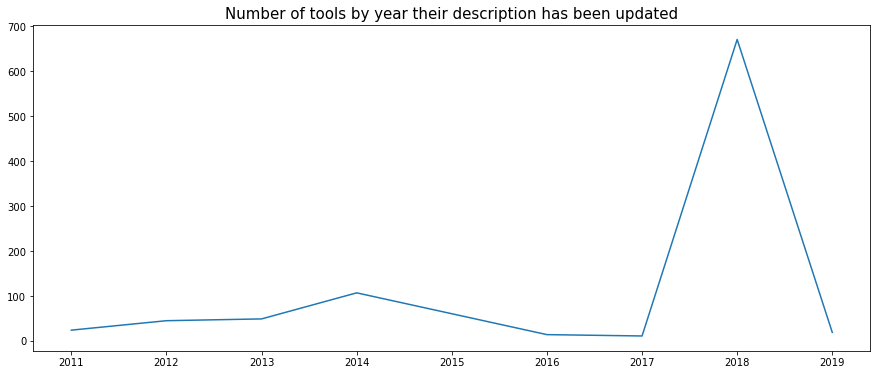

In [369]:
f, ax1 = plt.subplots(nrows=1, figsize=(15,6))
df_reg_tm_sorted.justdata.value_counts().reindex(sorted(df_reg_tm_sorted.justdata.value_counts().index)).plot(ax=ax1)
ax1.set_title('Number of tools by year their description has been updated', fontsize=15)

#### In TAPor dataset there are descriptions where the URL of the Tools is not provided

In [370]:
df_reg_tools_sub_emurl=df_reg_tools_sub[df_reg_tools_sub['url'] == '']
df_reg_tools_sub_emurl.count()

name            136
url             136
last_updated    136
dtype: int64

In [371]:
df_reg_tools_sub_whurl=df_reg_tools_sub[df_reg_tools_sub['url'] != '']
df_reg_tools_sub_whurl.index

Int64Index([423, 446, 444, 443, 442, 441, 440, 439, 438, 437,
            ...
            413, 414, 415, 416, 417, 418, 419, 420, 421, 422],
           dtype='int64', length=1227)

####  In TAPor dataset there are descriptions where the value for URL is 'None'

In [372]:
df_reg_tools_sub_whurl.tail(10)

,name,url,last_updated
413,AnnotateIt,None,None
414,PDFsam (PDF Split and Merge),None,None
415,Lightroom 5,None,None
416,PDFmyURL,None,None
417,Islandora,None,None
418,Intervue,None,None
419,Scalar,None,None
420,PDFCreator,None,None
421,Pulse Work,None,None
422,Lemon8-XML,None,None


In [373]:
#df_reg_tools_sub.head()
#for column in df_reg_tools_sub[['name', 'url']]:
#   # Select column contents by column name using [] operator
#   columnSeriesObj = df_reg_tools_sub[column]
#   print('Colunm Name : ', column)
#   print('Column Contents : ', columnSeriesObj.values)
df_urls=df_reg_tools_sub_whurl.url.values
#df_urls

In [374]:
data = {'url':  ['test'],'status': [1]}
df_http_status = pd.DataFrame (data, columns = ['url','status'])

In [387]:
import requests
import re
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)


for var in df_urls:
   # print(var)
    if ( var != "" and var!=None and re.match(regex, var)):
        try:
            r =requests.get(var,timeout=8)
            #print("result: "+var+ " ",r.status_code)
            df_http_status = df_http_status.append({'url': var, 'status': r.status_code}, ignore_index=True)
        except requests.exceptions.ConnectionError:
          #  print(var)
            df_http_status = df_http_status.append({'url': var, 'status': 503}, ignore_index=True)
        except requests.exceptions.ConnectTimeout:
          #  print(var)
            df_http_status = df_http_status.append({'url': var, 'status': 408}, ignore_index=True)
        except requests.exceptions.ReadTimeout:
         #   print(var)
            df_http_status = df_http_status.append({'url': var, 'status': 408}, ignore_index=True)
        except requests.exceptions.RequestException:
         #   print(var)
            df_http_status = df_http_status.append({'url': var, 'status': 500}, ignore_index=True)
        except TypeError:
        #    print(var)
            df_http_status = df_http_status.append({'url': var, 'status': 400}, ignore_index=True)
    else:
       # print(var ,0)
        df_http_status = df_http_status.append({'url': var, 'status': 400}, ignore_index=True)
df_http_status.head()

,url,status
0,test,1.0
1,http://taporware.ualberta.ca/~taporware/htmlTo...,404.0
2,http://taporware.ualberta.ca/~taporware/textTo...,404.0
3,http://taporware.ualberta.ca/~taporware/htmlTo...,404.0
4,http://taporware.ualberta.ca/~taporware/textTo...,404.0


### The HTTP result status values for URL in TAPoR descriptions

In [376]:
df_http_status_sub=df_http_status[df_http_status['status'] != 1]
df_db_st = df_http_status_sub['status'].value_counts()
df_db_st.head(10)

200.0    653
400.0    442
404.0     83
503.0     22
403.0     12
406.0      7
408.0      4
500.0      3
420.0      1
Name: status, dtype: int64

## TAPoR tools creators 
There are 164 records decribing tools that don't have values in *creators_name* field, and there are 924 different creators. 


In [4]:
df_db_tools_na=df_db_tools[df_db_tools['creators_name'] == ''].sort_values('last_updated')
df_db_tools_na.index

Int64Index([649, 686, 697, 701, 706, 719, 733, 736, 746, 765,
            ...
            405, 407, 408, 410, 412, 414, 416, 417, 420, 422],
           dtype='int64', length=164)

In [5]:
#the number of creators
len(df_db_tools['creators_name'].unique())-1

924

In [388]:
df_db_tools.loc[df_db_tools['creators_name']=='','creators_name']='n/a'
df_db_tech_NoCoT = df_db_tools['creators_name'].value_counts()

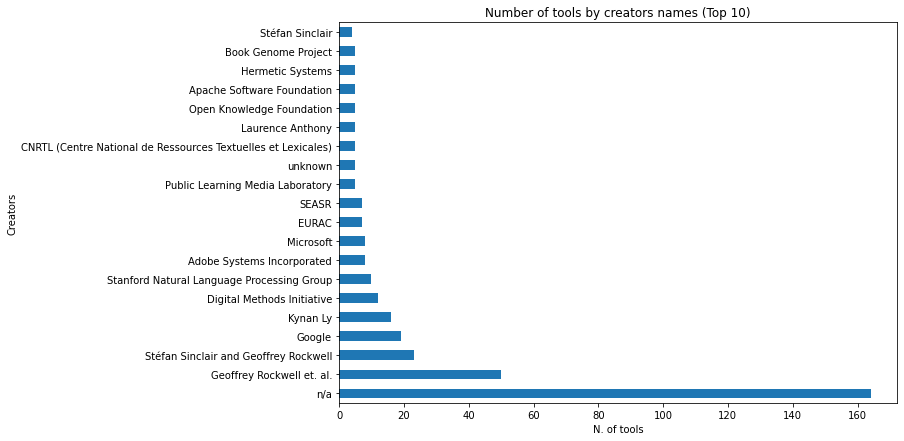

In [7]:
fig, ax = plt.subplots()
df_db_tech_NoCoT.head(20).plot.barh(figsize=(10,7), ax=ax)
ax.set_title('Number of tools by creators names (Top 10)')
ax.set_xlabel('N. of tools')
ax.set_ylabel('Creators');

Number of tools that don't have the related creator email

In [24]:
df_db_tools_naem=df_db_tools[df_db_tools['creators_email'] == ''].sort_values('last_updated')
df_db_tools_naem.index

Int64Index([ 441,  442,  443,  472,  473,  482,  480,  479,  481,  477,
            ...
            1320, 1344, 1345, 1350, 1351, 1352, 1353, 1356, 1355, 1357],
           dtype='int64', length=382)

Number of tools that don't have the related creator URL

In [25]:
df_db_tools_nau=df_db_tools[df_db_tools['creators_url'] == ''].sort_values('last_updated')
df_db_tools_nau.index

Int64Index([ 512,  517,  518,  521,  529,  530,  535,  539,  541,  542,
            ...
            1325, 1324, 1323, 1319, 1318, 1328, 1345, 1356, 1355, 1357],
           dtype='int64', length=171)

# ------ 

In [8]:
df_db_tech=pd.read_sql_query('select t.id, t.name, t.detail, t.creators_name, t.last_updated, at.name as "attributetype", av.name as"attribute", tags.text as "tag" from TaPOR.tools as t, TaPOR.attribute_values as av, TaPOR.tool_attributes as ta, TaPOR.attribute_types as at, TaPOR.tags as tags, TaPOR.tool_tags as tota where t.is_approved=1 and t.id=ta.tool_id and t.id=tota.tool_id and tags.id=tota.tag_id and ta.attribute_value_id=av.id and ta.attribute_type_id=at.id', connection)
#df_db_tech=pd.read_sql_table('tools', connection)

In [9]:
#df_db_tech.head(10)

In [10]:
df_db_tech.index

RangeIndex(start=0, stop=43845, step=1)

In [11]:
df_db_tech.columns

Index(['id', 'name', 'detail', 'creators_name', 'last_updated',
       'attributetype', 'attribute', 'tag'],
      dtype='object')

In [13]:
df_items=df_db_tech[['id', 'name', 'detail', 'creators_name', 'last_updated']].drop_duplicates()
#df_items.head(10)

## Attributes in TAPoR items

The following dataframe shows the list of attribute types defined in TaPOR to charachteriza tools

In [20]:
df_db_tools_toa=pd.read_sql_query('SELECT distinct name FROM TaPOR.attribute_types', connection)
df_db_tools_toa.head(20)

,name
0,Type of analysis
1,Type of license
2,Background Processing
3,Web Usable
4,Ease of Use
5,Warning
6,Usage
7,Tool Family
8,Historic Tool (developed before 2005)
9,Compute Canada


### Tools with no attribute

The following dataframe shows the main fields of tools that does not have attributes

In [23]:
df_db_tools_noatt=pd.read_sql_query('select distinct tools.id, tools.name, tools.creators_name, tools.url from TaPOR.tools where tools.is_approved=1 and tools.id not in (select distinct TaPOR.tool_attributes.tool_id from TaPOR.tool_attributes)', connection)
df_db_tools_noatt.head(13)

,id,name,creators_name,url
0,579,Voyant 2.0: Knots,Stéfan Sinclair and Geoffrey Rockwell,http://voyant-tools.org/?view=knots
1,591,Warc Extractor,Ryan Chartier & Internet Archive,https://github.com/recrm/ArchiveTools/blob/mas...
2,754,TAGS https://t.co/T007ezdZoA,,None
3,755,Multiple enhancements to DiRT Directory (tools...,,None
4,758,"RT : Today's ""dirt"": DiRT now uses TaDiRAH ter...",,None
5,823,Basement Waterproofing: Tips and Instructions,,None
6,1017,Datapress,MIT CSAIL,None
7,1063,WordVenture,WordNet,None
8,1174,VoiceThread,VoiceThread LLC,None
9,1183,Purdue OWL,"Purdue University Writing Lab, Purdue Universi...",None


## Type of Licenses in TAPoR items

In [35]:
df_db_sub=df_db_tech[['id', 'name', 'detail', 'creators_name', 'last_updated', 'attributetype', 'attribute']]
df_to=df_db_sub[df_db_sub['attributetype'] == 'Type of license'].drop_duplicates()
df_to.index

Int64Index([    8,    40,    44,   108,   170,   306,   330,   344,   362,
              380,
            ...
            43679, 43728, 43730, 43751, 43762, 43779, 43814, 43816, 43821,
            43824],
           dtype='int64', length=1024)

In [38]:
df_db_lic = df_to['attribute'].value_counts()
df_db_lic.head(10)

Free                470
Open Source         256
Closed Source       195
Commercial           79
Creative Commons     22
Shareware             2
Name: attribute, dtype: int64

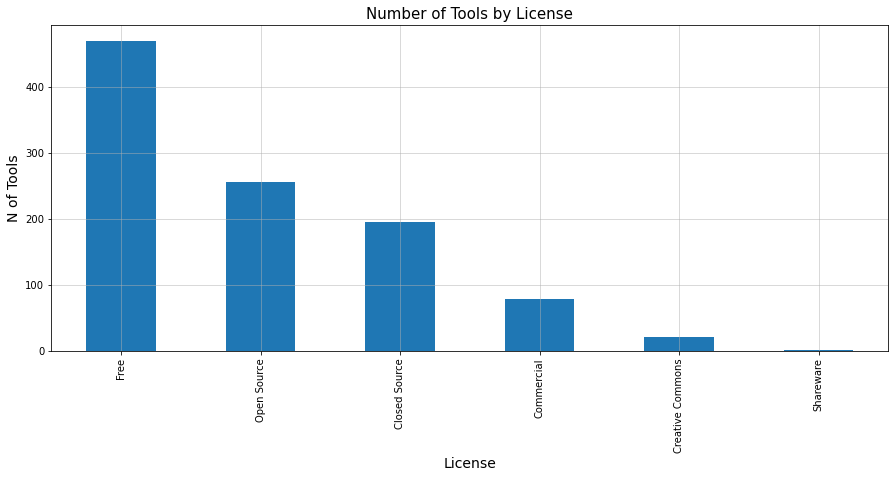

In [36]:
fig, ax = plt.subplots()
df_db_lic.plot(kind='bar', figsize=(15,6), x='licences', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by License", fontsize=15)
ax.set_xlabel('License', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

In [29]:
#df_db_tech.loc[df_db_tech['country']=='', 'country']='N/A'

## Type of analysis attributes in TAPoR items

The attribute *Type of analysis* can have multiple values (i.e. a tool can perform one or more type of analysis)

In [43]:
df_to_ta=df_db_sub[df_db_sub['attributetype'] == 'Type of analysis'].drop_duplicates()
df_to_ta.head()

,id,name,detail,creators_name,last_updated,attributetype,attribute
20,1,List Words - HTML (TAPoRware),"<p>This tool lists words in an HTML document, ...",Geoffrey Rockwell et. al.,2011-11-27,Type of analysis,Analysis
32,4,Wordle,<p>Wordle is an online toy for generating <a h...,Jonathan Feinberg,2018-10-17,Type of analysis,Visualization
36,4,Wordle,<p>Wordle is an online toy for generating <a h...,Jonathan Feinberg,2018-10-17,Type of analysis,Analysis
76,5,OrlandoVision (OVis),<p>An application for visualizing a specific c...,The Orlando Project,2018-11-01,Type of analysis,Visualization
78,5,OrlandoVision (OVis),<p>An application for visualizing a specific c...,The Orlando Project,2018-11-01,Type of analysis,Analysis


In [41]:
df_db_a = df_to_ta['attribute'].value_counts()
df_db_a.head(25)

Analysis                       434
Visualization                  236
Content Analysis               185
Search                         139
Natural Language Processing    125
Discovering                    124
Capture                        113
Gathering                       97
Publishing                      92
Dissemination                   91
Enrichment                      90
Annotating                      83
Collaboration                   80
Organizing                      71
Creation                        52
Uncategorized                   49
Storage                         40
Web development                 39
Modeling                        25
Programming                     22
Interpretation                  18
RDF                             12
Name: attribute, dtype: int64

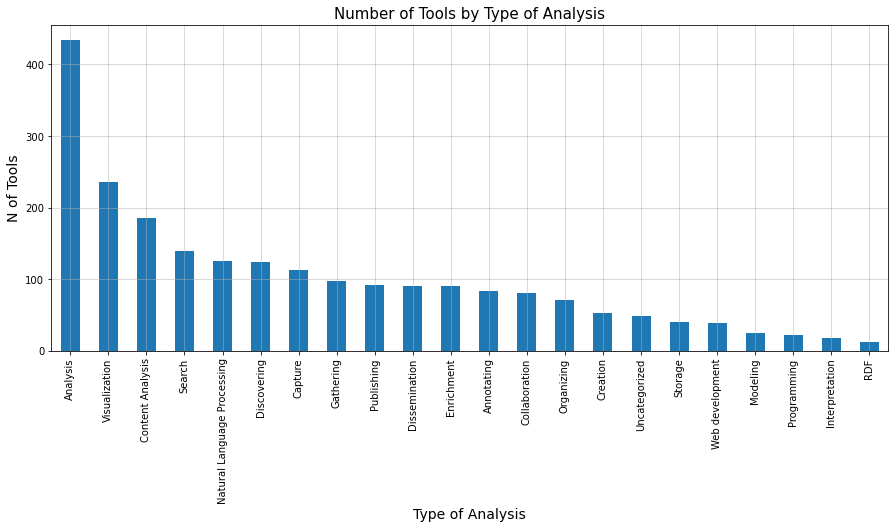

In [34]:
fig, ax = plt.subplots()
df_db_a.plot(kind='bar', figsize=(15,6), x='analysys', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by Type of Analysis", fontsize=15)
ax.set_xlabel('Type of Analysis', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

## Tool families in TAPoR items

In [47]:
df_to_tf=df_db_sub[df_db_sub['attributetype'] == 'Tool Family'].drop_duplicates()
df_to_tf = df_to_tf['attribute'].value_counts()
df_to_tf.head(20)

TAPoRware                     55
Voyant                        18
Digital Methods Initiative    12
Stanford NLP                  11
SEASR                          8
SIMILE Widgets                 6
Visualizing Literature         5
Book Genome Project            5
EURAC                          5
CNRTL                          5
CHNM                           4
Orlando                        3
Laurence Anthony               3
Stanford Vis Group             2
Scholars' Lab                  2
Stanford HCI Group             2
Name: attribute, dtype: int64

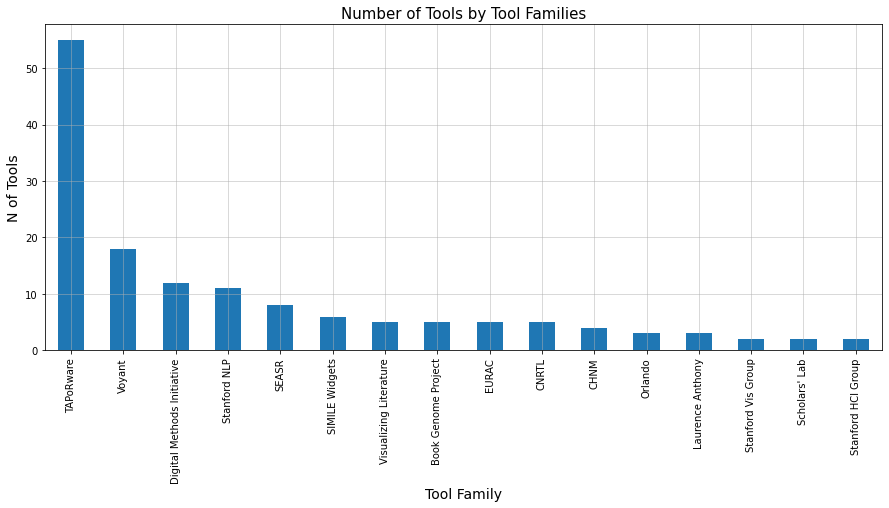

In [48]:
fig, ax = plt.subplots()
df_to_tf.plot(kind='bar', figsize=(15,6), x='analysys', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by Tool Families", fontsize=15)
ax.set_xlabel('Tool Family', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

## Web Usable attributes in TAPoR items

In [56]:
df_to_bp=df_db_sub[df_db_sub['attributetype'] == 'Web Usable'].drop_duplicates()
df_to_bp.head()

,id,name,detail,creators_name,last_updated,attributetype,attribute
16,1,List Words - HTML (TAPoRware),"<p>This tool lists words in an HTML document, ...",Geoffrey Rockwell et. al.,2011-11-27,Web Usable,Run in Browser
52,4,Wordle,<p>Wordle is an online toy for generating <a h...,Jonathan Feinberg,2018-10-17,Web Usable,Run in Browser
82,5,OrlandoVision (OVis),<p>An application for visualizing a specific c...,The Orlando Project,2018-11-01,Web Usable,Software you Download and Install
118,8,Voyant Cirrus,<p>Cirrus is a visualization tool that display...,Stéfan Sinclair and Geoffrey Rockwell,2018-10-05,Web Usable,Run in Browser
192,9,Voyant Links,<p>Links finds collocates for words and displa...,Stéfan Sinclair and Geoffrey Rockwell,2018-09-18,Web Usable,Run in Browser


In [57]:
df_to_bp = df_to_bp['attribute'].value_counts()
df_to_bp.head(10)

Run in Browser                       503
Other                                400
Software you Download and Install    187
Web Application you Launch             8
Name: attribute, dtype: int64

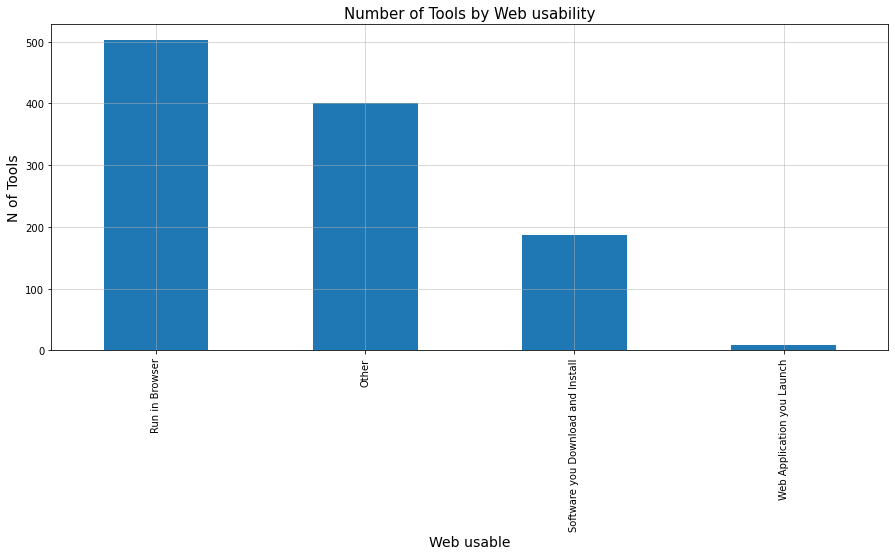

In [60]:
fig, ax = plt.subplots()
df_to_bp.plot(kind='bar', figsize=(15,6), x='webusable', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by Web usability", fontsize=15)
ax.set_xlabel('Web usable', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

## ------

import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
sdg_classes = list(range(1, 27))
mlb = MultiLabelBinarizer(classes=sdg_classes)
sdg_goals_mlb = pd.DataFrame(mlb.fit_transform(df_db_tech['country']), columns=mlb.classes_)

sdg_goals_mlb.head()

sdg_goals_mlb.sum()


#create a new plot with default tools, using figure
p = figure(plot_width=400, plot_height=400)

#add a circle renderer with x and y coordinates, size, color, and alpha
p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=15, line_color="navy", fill_color="orange", fill_alpha=0.5)

show(p) # show the results

pd.set_option('display.max_rows', 200)
df_db_techtable=pd.read_sql_table('Technique', connection)
df_db_techtable.head()


df_db_techtable[['name', 'description', 'notes']].duplicated()

db_tech_table_nodupl=df_db_techtable[['name', 'description', 'notes']].drop_duplicates()

db_tech_table_nodupl.count()

df_db_techtable.count()